<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/4_classification_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Hyperparameter tuning

Want the best performance of your ML model without unnecessary complexity? This workshop will explore **hyperparameter tuning** techniques to optimise your model, improve accuracy, and reduce resource usage. Think of your ML model as a tool—like a hammer. If you're new to a task, you might use an adequate tool, but your technique may not be optimal. How you hold the hammer, its size, and the impact angle all act as "hyperparameters". Tuning (adjusting) these paramaters helps you get better results across different situations (like hammering nails into softwood vs. hardwood). We aim to find the best configuration that improves performance while keeping things efficient.

<figure>
    <img src="images/hyper_tuning_chatgpt.png" width="400">
    <figcaption>Figure 1: Hyperparameter tuning visualization - ChatGPT</figcaption>
</figure>


Let's start with a simple example using a dataset that we have used before for other workshops. If you remember correctly, for the Random Forest and feature importance workshop, we use the dataset provided by [Hauswirth et al. (2021)](https://doi.org/10.1016/j.advwatres.2021.104017). The task was to predict the water level at the Hagestein station using a selection of five meteorological and hydrological variables: the discharge of the Rhine (QRHINE) and Meuse (QMEUSE) at the Dutch border, the water level of the North Sea (WLHv), precipitation (RH) and evaporation (EV24).

## Data split

In previous workshops, we split the dataset into **training** and **test** sets, but now, to properly tune the hyperparameters, we'll also introduce a **validation set**. This allows us to optimise the hyperparameters on the training and validation sets while reserving the test set for unbiased final evaluation. There are many ways to split your dataset, but for **time-series** data, it's crucial to ensure that the **test set** represents **future** data, as it simulates how the model would perform on unseen data over time. Therefore, **we cannot split the dataset randomly**.

For this example we are going to use **60% of the dataset for training**, **20% for validation**, **and 20% for testing**. There is not perfect way to define the proportions, but this might be influenced by the amount of data you have.

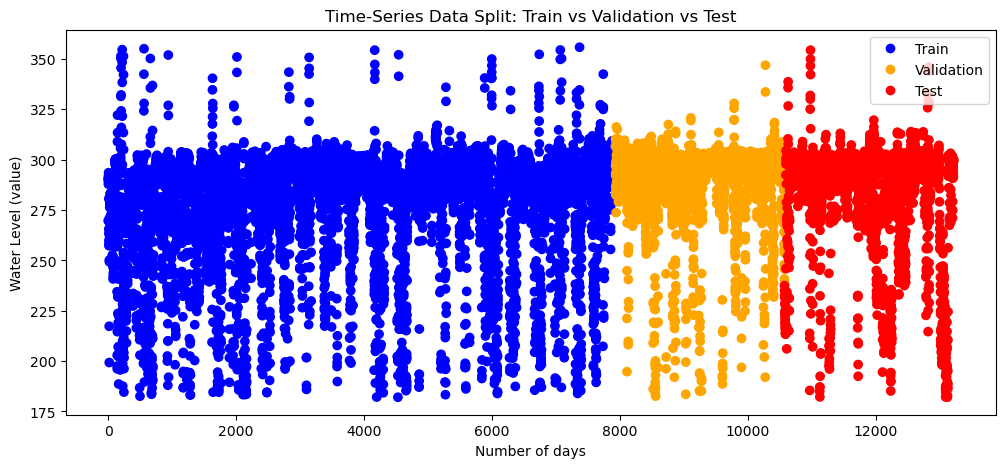

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data_url = "https://raw.githubusercontent.com/Jignesh1594/CodeGeoworkshop_02_understanding_RF/master/data.csv"
data = pd.read_csv(data_url, delimiter=",", on_bad_lines='skip')

# Select input and output variables
input_data = data[['WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine']]
output_data = data['value']

# Chronological Train-Test Split
train_size = int(0.80 * len(input_data))  # 80% for training/validation, 20% for testing

X_trainval, X_test = input_data.iloc[:train_size], input_data.iloc[train_size:]
y_trainval, y_test = output_data.iloc[:train_size], output_data.iloc[train_size:]

# Further Split Training Data into Train and Validation Sets
train_size = int(0.75 * len(X_trainval))  # 75% for training, 25% for validation. In total 60% training / 20% validation / 20% testing

X_train, X_val = X_trainval.iloc[:train_size], X_trainval.iloc[train_size:]
y_train, y_val = y_trainval.iloc[:train_size], y_trainval.iloc[train_size:]

# Create a new column to label the dataset
data['Dataset'] = 'Test'  # Default label

data.iloc[:len(X_train), data.columns.get_loc('Dataset')] = 'Train'
data.iloc[len(X_train):len(X_train) + len(X_val), data.columns.get_loc('Dataset')] = 'Validation'

# Plot the dataset labeling
plt.figure(figsize=(12, 5))
plt.scatter(data.index, data['value'], c=data['Dataset'].map({'Train': 'blue', 'Validation': 'orange', 'Test': 'red'}), label="Data Points")
plt.xlabel("Number of days")
plt.ylabel("Water Level (value)")
plt.title("Time-Series Data Split: Train vs Validation vs Test")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Train'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='Validation'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Test'),
])

plt.show()


## Tuning a single hyperparameter

Our "hammer" for this task will be .... **Random Forest!** Depending on the implementation of this method, you can tune different hyperparameters. For example, for the [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) you can tune, among others, the number of decision trees (**n_estimators**), the maximum depth of the trees(**max_depth**), or the minimum number of samples required to split an internal node (**min_samples_split**). Deciding the best hyperparameter to tune is already an important decision, but for now, we will select only one: **min_samples_split**. As you remember from previous workshops, **Random Forest** is a collection of many decision trees, so **min_samples_split** hyperparameter is inherited from the [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) model itself.

Below, we visually illustrate the difference between using a different **min_samples_split** value and using a synthetic dataset for a single decision tree. In short, with this hyperparameter, you decide when a tree stops branching. If this does not make sense to you, check out our [Workshop about Random Forest](https://github.com/oriol-pomarol/codegeo_workshops/blob/main/1_understanding_random_forest.ipynb)! In general, you will have more branches ('decision nodes') if the **min_samples_split** value is smaller. This can significantly affect the generalisation ability of your model (underfitting/overfitting), but this is a topic for a future workshop. This also has implications for the resources you need for the model. More "decision nodes" require more computations.

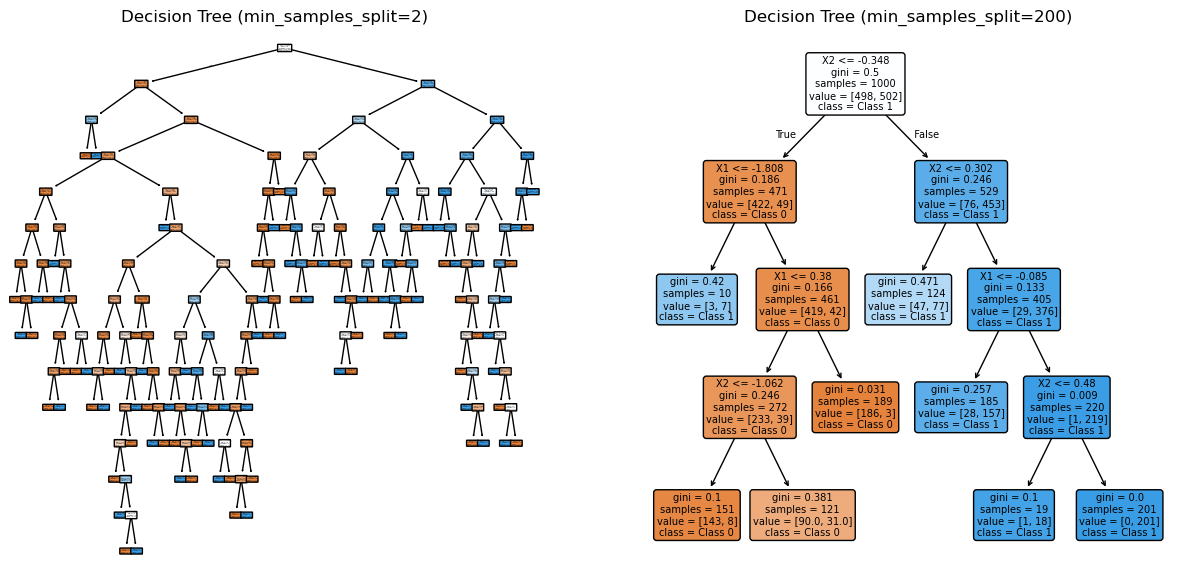

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1. Generate synthetic data (2 features)
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=42)

# 2. Train Decision Tree with min_samples_split = 2
tree1 = DecisionTreeClassifier(min_samples_split=2, random_state=42)
tree1.fit(X, y)

# 3. Train Decision Tree with min_samples_split = 200
tree2 = DecisionTreeClassifier(min_samples_split=200, random_state=42)
tree2.fit(X, y)

# 4. Plot the trees
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

plot_tree(tree1, filled=True, ax=axes[0], feature_names=['X1', 'X2'], class_names=['Class 0', 'Class 1'], rounded=True)
axes[0].set_title("Decision Tree (min_samples_split=2)")

plot_tree(tree2, filled=True, ax=axes[1], feature_names=['X1', 'X2'], class_names=['Class 0', 'Class 1'], rounded=True)
axes[1].set_title("Decision Tree (min_samples_split=200)")

plt.show()


## Tuning the min_samples_split hyperparameter

Now that we know what the hyperparameter we selected (**min_samples_split**)is doing, we can start finding a good configuration. The most simple (yet inefficient) approach is to map the effect of changing the number of this hyperparameter. We train the Random Forest model using the **train set** and evaluate the performance using the **validation set**. Here, we check the **mean square error** between the expected values of the **validation set** and the predictions. This will be our **criteria** to decide the better or worse result. Below, we select values between 2 and 250. Do you know why we selected that range (**24 hyperparameter configurations**)? Does that make sense to you?

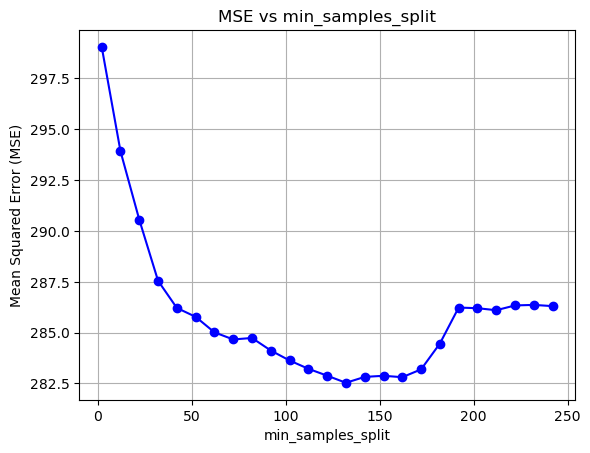

In [4]:
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# List to store MSE for each value of min_samples_split
mse_values = []
min_samples_split_values = range(2, 250, 10)
hyperparameter_configurations = []  # To store the hyperparameter configurations

# For loop to train models with different min_samples_split values
for min_samples in min_samples_split_values:
    # Create and train the model
    model = ensemble.RandomForestRegressor(n_estimators=100, min_samples_split=min_samples, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions and calculate MSE
    y_pred = model.predict(X_val)
    mse = metrics.mean_squared_error(y_val, y_pred)
    
    # Store the MSE value
    mse_values.append(mse)
    hyperparameter_configurations.append({'min_samples_split': min_samples, 'mse': mse})

# Plotting the MSE for each min_samples_split value
plt.plot(min_samples_split_values, mse_values, marker='o', linestyle='-', color='b')
plt.title("MSE vs min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()


According to the results, the mean squared error (MSE) is low (around 283) when **min_samples_split** ranges from 122 to 162. Notice that the default **min_samples_split** value (2) actually results in the highest MSE for the validation set.

In [8]:
# MSE per hyperparameter configuration
hyperparameter_df = pd.DataFrame(hyperparameter_configurations)

# Sort the table by MSE
hyperparameter_df = hyperparameter_df.sort_values(by='mse')

# Display the table
print("Hyperparameter configurations and their corresponding MSE:")
hyperparameter_df.head()

Hyperparameter configurations and their corresponding MSE:


,min_samples_split,mse
13,132,282.533404
16,162,282.808143
14,142,282.822519
15,152,282.877268
12,122,282.882249


Above, you can see the top 5 configurations. Differences are small, so it might be hard to select a specific one, but if you want to be sure, we are going to select the best hyperparameter configuration.

In [9]:
# Finding the best configuration
best_configuration = hyperparameter_df.iloc[0]
best_sample_split = int(best_configuration.iloc[0])
# Print the best configuration
print("Best min_samples_split configuration:")
print(best_sample_split)

Best min_samples_split configuration:
132


# Re-train model using training and validation sets with the best hyperparameter

We now know that 132 is a good value for **min_samples_split**, so we will re-train our model using the train and validation set using that hyperparameter.

In [10]:
# Combine training and validation sets 
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

# Train the model again using the training data with the best hyperparameter configuration
best_model = ensemble.RandomForestRegressor(min_samples_split=best_sample_split, random_state=42)
best_model.fit(X_trainval, y_trainval)


RandomForestRegressor(min_samples_split=132, random_state=42)

What happens if we evaluate the model on the validation set? (Remember, we are using the validation set for training.)

In [11]:
# Evaluate the model on the validation set again
y_val_pred = best_model.predict(X_val)
val_mse = metrics.mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on Validation Set after Retraining: {val_mse}")

Mean Squared Error on Validation Set after Retraining: 180.08499335010012


The Mean Squared Error is very low. However, this is misleading because we use the **validation test** twice. First, we use it for hyperparameter tuning, and then we use it for re-training. So your model 'knows' a lot about your **validation set** and is going to be very good at making predictions for that set. That's why, to evaluate the model in a fair way, we need to do it on unseen data (**test set**).

In [12]:
# Evaluate the model on the test set again
y_test_pred = best_model.predict(X_test)
val_mse_h = metrics.mean_squared_error(y_test, y_test_pred)

print(f"Mean Squared Error on Test Set (Unseen data) after Retraining: {val_mse_h}")

Mean Squared Error on Test Set (Unseen data) after Retraining: 278.9864286366875


# Effects hyperparameter tuning

Ok, so we know that if we re-train (using the train+validation sets) using the best hyperparameter, we end up with an MSE of around (279). However, is this better than completely ignoring hyperparameter tuning and just using the default value? To check this, we train a model using the default hyperparameters (in this case, min_samples_split equals 2).

In [13]:
# Train the model again using the training + validation data
default_model = ensemble.RandomForestRegressor(random_state=42)
default_model.fit(X_trainval, y_trainval)

# Evaluate the model on the validation set again
y_test_pred_default = default_model.predict(X_test)
val_mse_def = metrics.mean_squared_error(y_test, y_test_pred_default)

print(f"Mean Squared Error on Validation Set after Retraining: {val_mse_def}")

Mean Squared Error on Validation Set after Retraining: 284.64661155893714


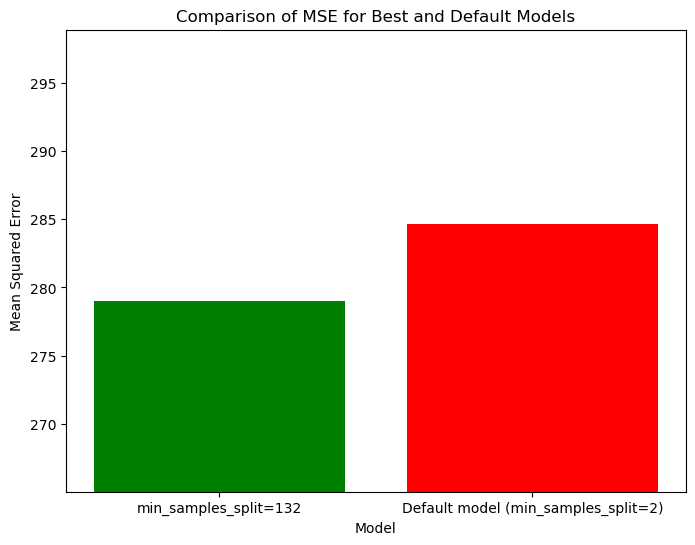

In [14]:
import matplotlib.pyplot as plt

# Values for MSE
val_mse = [val_mse_h, val_mse_def]
model_names = ["min_samples_split=132", 'Default model (min_samples_split=2)']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(model_names, val_mse, color=['green', 'red'])

# Adjust the y-axis limits to emphasize the differences
min_mse = min(val_mse)
max_mse = max(val_mse)
plt.ylim(min_mse * 0.95, max_mse * 1.05)  # Adjust limits to zoom in

# Add labels and title
plt.title('Comparison of MSE for Best and Default Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')

# Show the plot
plt.show()


We can get better results than the default configuration using the hyperparameter we found during hyperparameter tuning. So, we improved our model for our prediction by simply modifying one hyperparameter. But how does that look in the final prediction? Below, you can see the absolute difference between the expected value and the two predictions (model using best hyperparameter vs Default model)

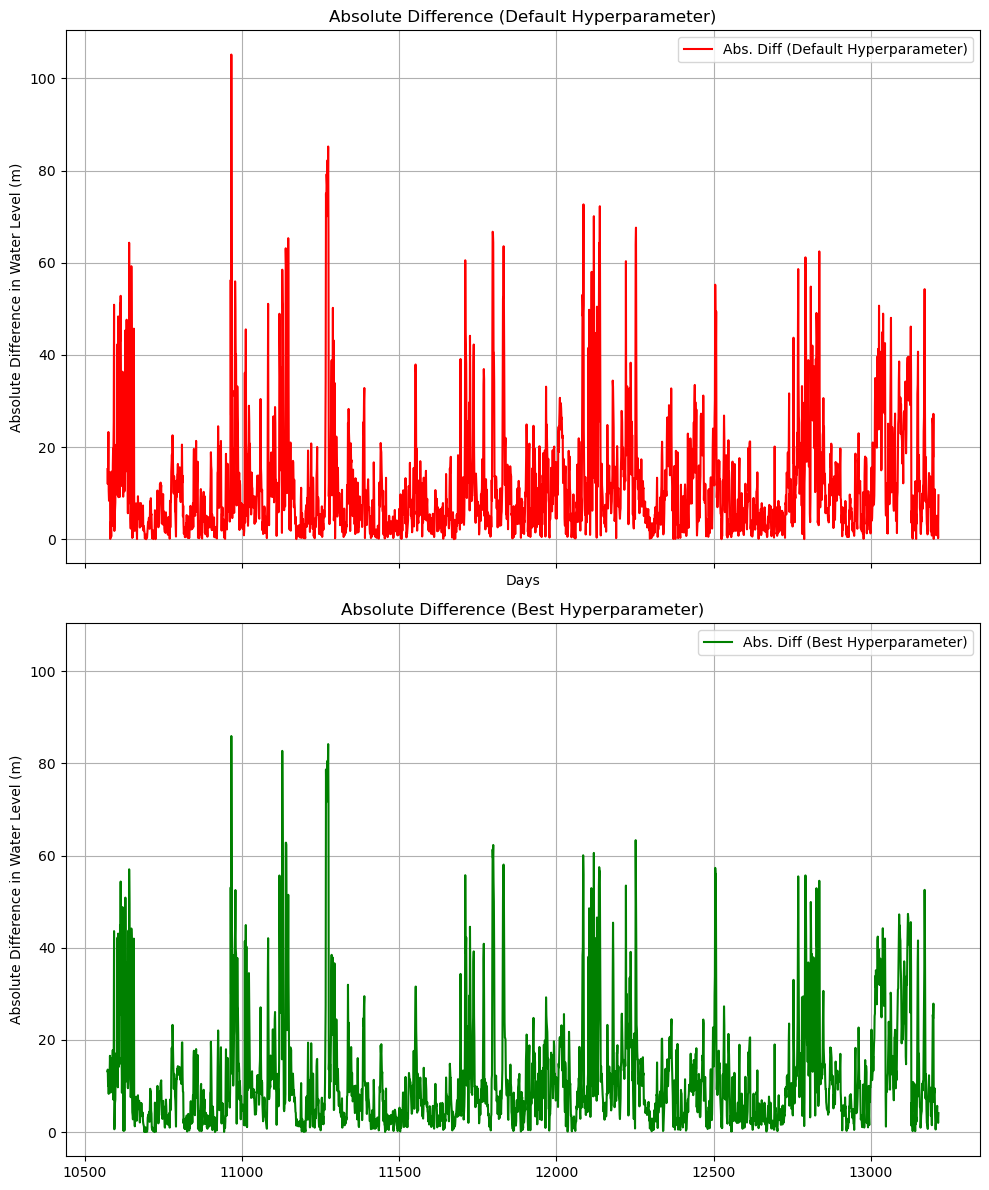

In [15]:
import matplotlib.pyplot as plt

# Calculate absolute differences
abs_diff_best = abs(y_test - y_test_pred)
abs_diff_default = abs(y_test - y_test_pred_default)

# Create subplots with shared x-axis
fig, ax = plt.subplots(2, 1, figsize=(10, 12), sharex=True, sharey=True)

# Plot Absolute Difference for Default Hyperparameter
ax[0].plot(y_test.index, abs_diff_default, label="Abs. Diff (Default Hyperparameter)", color='red')
ax[0].set_title("Absolute Difference (Default Hyperparameter)")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Absolute Difference in Water Level (m)")
ax[0].legend()
ax[0].grid(True)

# Plot Absolute Difference for Best Hyperparameter
ax[1].plot(y_test.index, abs_diff_best, label="Abs. Diff (Best Hyperparameter)", color='green')
ax[1].set_title("Absolute Difference (Best Hyperparameter)")
ax[1].set_ylabel("Absolute Difference in Water Level (m)")
ax[0].set_xlabel("Days")
ax[1].legend()
ax[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()